## Task 2- Market Sentiment Analysis

In [1]:
# Load Dataset
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import math
import re
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Load data
df = pd.read_csv("../../data/news_data.csv")

# Preview data
df.sample(5)



,Headline,Date,Sentiment Score,Organization Names
79,Germany and EU Invest Over €1 Billion to Prope...,2024-02-02 11:53:17,0.980611,"['EU', 'SolarQua']"
95,Lhyfe Starts Building a New Green Hydrogen Pro...,2024-02-02 08:00:00,0.655757,"['Lhyfe', 'DirectIndustry e']"
73,Linde Commences Delivery of Green Hydrogen and...,2024-02-01 11:43:24,0.773823,"['Lin', '##ydro', 'ChemAnalys']"
65,Egypt launches 55% tax credit to boost green h...,2024-02-02 11:07:29,0.880538,['ETN News']
84,Green Hydrogen – Shipping and Steel Sectors - ...,2024-02-05 08:47:52,0.994936,"['Green Hydrogen – Shipping and Steel Sector',..."


In [2]:
# Clean the text data
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = text.lower()                  # Convert to lowercase
    return text

df['cleaned_text'] = df['Headline'].apply(clean_text)

### 1. Sentiment Trend

In [3]:
df_time_analysis = df.copy()

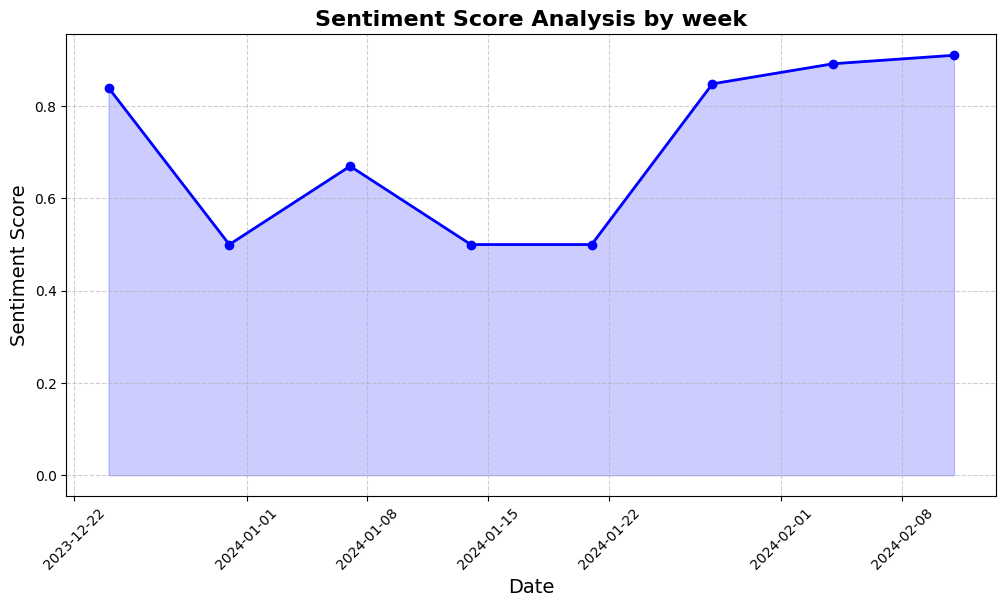

In [4]:
# Note: Weeks without any entries are depicted as 0.5 for convenience.
df_time_analysis['Date'] = pd.to_datetime(df_time_analysis['Date'])
df_time_analysis.set_index('Date', inplace=True)
weekly_sentiment = df_time_analysis.resample('W')['Sentiment Score'].mean().fillna(0.5)
plt.figure(figsize=(12, 6))
plt.plot(weekly_sentiment.index, weekly_sentiment, marker='o', linestyle='-', color='b', linewidth=2, markersize=6)
plt.fill_between(weekly_sentiment.index, weekly_sentiment, color='b', alpha=0.2)
plt.title('Sentiment Score Analysis by week', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=14)
plt.xticks(rotation=45)  
plt.grid(True, linestyle='--', alpha=0.6)  
plt.show()



### 2. Sentiment Grouping

In [5]:
df["Sentiment Score"].describe()

count    99.000000
mean      0.896015
std       0.130053
min       0.500607
25%       0.832696
50%       0.962949
75%       0.988966
max       0.999358
Name: Sentiment Score, dtype: float64

In [6]:
def assign_sentiment_label(score):
    if score > 0.63:
        return "Positive"
    elif score > 0.50:
        return "Neutral"
    else:
        return "Negative"
df["Sentiment Label"] = df["Sentiment Score"].apply(assign_sentiment_label)

### 3. Tagging/Clustering

In [7]:
def avg_word_count(text):
    words = text.split()
    return len(words)

df['Word_Count'] = df['Headline'].apply(avg_word_count)
avg_word_count_var = df['Word_Count'].mean()
avg_word_count_var = math.floor(avg_word_count_var)
tfidf = TfidfVectorizer(max_features=avg_word_count_var-2, stop_words="english")  # Top n-2 (12) keywords, excluding stop words 
tfidf_matrix = tfidf.fit_transform(df["cleaned_text"])
keywords = tfidf.get_feature_names_out()

df["Keywords"] = [
    ", ".join([keywords[i] for i in tfidf_matrix[row].nonzero()[1]])
    for row in range(tfidf_matrix.shape[0])
]



In [8]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)
df["Cluster"] = clusters


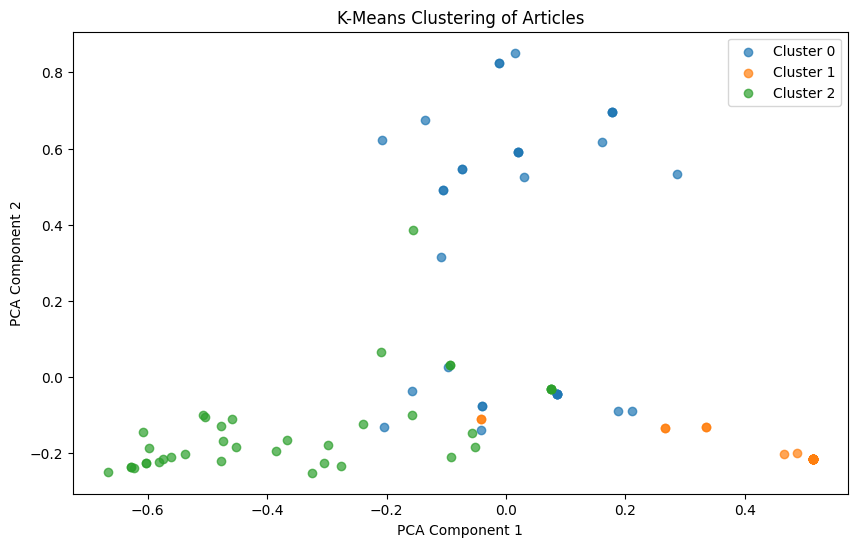

In [9]:
# Reduce dimensions for visualization
pca = PCA(n_components=2, random_state=42)
# Note: Success of the model is dependent on the random state, but it works fine with rs value of 42.
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_points = reduced_data[df["Cluster"] == cluster]
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        label=f"Cluster {cluster}",
        alpha=0.7
    )

plt.title("K-Means Clustering of Articles")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


In [10]:
# To see keywords. 
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_row', None)
# df[["Keywords", "Cluster"]]

In [11]:
# These categories are based on human interpretation.
def categorizer(cluster):
    if cluster == 2:
        return "Production"
    if cluster == 0:
        return "Energy / Local"
    if cluster == 1:
        return "Rest"
df["Cluster_Categories"]  = df["Cluster"].apply(categorizer)
df.head()

,Headline,Date,Sentiment Score,Organization Names,cleaned_text,Sentiment Label,Word_Count,Keywords,Cluster,Cluster_Categories
0,"""Once Volume Increases, Green Hydrogen Will Co...",2024-02-06 12:51:44,0.996130,"['Green H', 'Oil India', 'NDTV']",once volume increases green hydrogen will cost...,Positive,14,"green, hydrogen, india",0,Energy / Local
1,Envision Energy Partners with BASF to Boost Gr...,2024-02-06 12:25:00,0.998004,"['Envision Energy Partners', 'BASF', 'Bo', '##...",envision energy partners with basf to boost gr...,Positive,16,"green, hydrogen, energy",0,Energy / Local
2,Green hydrogen: Proposals for projects worth ₹...,2024-02-04 02:32:04,0.972791,['Hindustan Times'],green hydrogen proposals for projects worth 27...,Positive,15,"green, hydrogen, energy, projects",0,Energy / Local
3,5 ways to make green hydrogen available around...,2024-02-05 17:30:45,0.997399,"['World Economic Forum', 'World Economic Forum']",5 ways to make green hydrogen available around...,Positive,18,"green, hydrogen",1,Rest
4,IIPE in Visakhapatnam launches a pilot project...,2024-02-04 19:15:00,0.905727,"['IIPE', 'NTPC']",iipe in visakhapatnam launches a pilot project...,Positive,18,"green, hydrogen, pilot, project",2,Production


In [12]:
df["Cluster"].value_counts()

Cluster
2    38
0    32
1    29
Name: count, dtype: int64

### 4. Word Cloud for Visualization Purposes

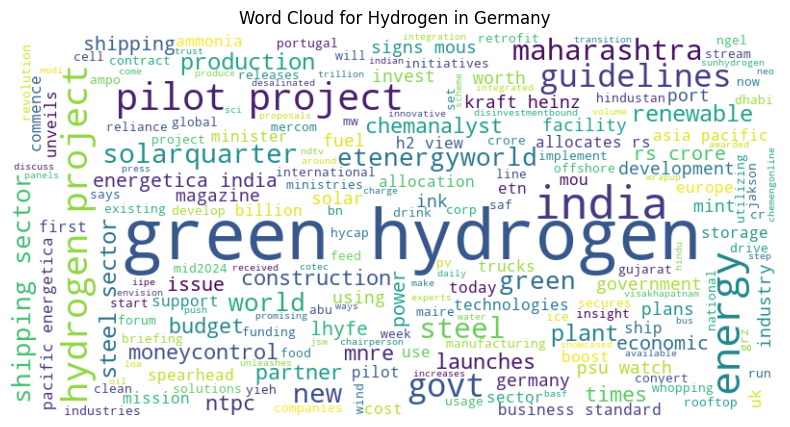

In [13]:
# Word Cloud for Articles
german_text = " ".join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(german_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Hydrogen in Germany")
plt.show()